In [1]:
import pandas as pd
import pandas_datareader
import numpy as np
import scipy.stats

import requests
import re
import json
from bs4 import BeautifulSoup
import yfinance as yf

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)

In [2]:
from lib.attribution.famma_french import FammaFrench
from lib.attribution.value_at_risk import VaR
from lib.attribution.pca_var import PCA_VaR
from lib.calendar import Calendar
from lib.nasdaq import Nasdaq, Tickers
cal = Calendar()

In [3]:
import warnings
warnings.filterwarnings('ignore')

Attributes the performance of a portfolio to various market factors. Measures the contribution of each factor to the total or excess return of the portfolio.
<ul>
    <li>Famma French</li>
    <li>Brinson</li>
    <li>Value at Risk</li>
</ul>

# Portfolio

In [4]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:83.0) Gecko/20100101 Firefox/83.0"
}

def main(url, tickers):
    with requests.Session() as req:
        req.headers.update(headers)    
        frames = []
        for key in tickers:
            r = req.get(url.format(key))
            print(f"Extracting: {r.url}")      
            rows = []
            for line in r.text.splitlines():
                if not line.startswith('etf_holdings.formatted_data'):
                    continue
                data = json.loads(line[30:-1])
                for holding in data:
                    goal = re.search(r'etf/([^"]*)', holding[1])
                    if goal:
                        rows.append([goal.group(1), *holding[2:5]])
            df = pd.DataFrame(rows, columns = ['Symbol', 'Shares', 'Weight', '52 week change'])
            for err in ['NaN', 'NA', 'nan']:
                df["Weight"] = df['Weight'].apply(lambda x : x.replace(err, ''))
            
            df.dropna(how='any', axis=0, inplace=True)
            df = df[['Symbol', 'Shares', 'Weight']]
            df['Shares'] = pd.to_numeric([x.replace(',','') for x in df['Shares']])
            df['Weight'] = pd.to_numeric(df['Weight'])
            df.dropna(how='any', axis=0, inplace=True)

            frames.append(df)
    return frames
            
portfolio = main(url = "https://www.zacks.com/funds/etf/{}/holding", tickers = [ 'SPY' ])

Extracting: https://www.zacks.com/funds/etf/SPY/holding


# Holdings

In [5]:
portfolio[0].head()

Symbol     Shares  Weight
0   AAPL  166827740    6.63
1   MSFT   81147040    6.03
2   AMZN   94936456    3.01
3  GOOGL    3263309    2.12
4   GOOG    2992084    1.96

In [6]:
pf = portfolio[0]

# Returns

In [7]:
ff = FammaFrench(symbols = pf.Symbol.tolist(), weights = pf.Weight.tolist())

In [8]:
portf_returns = ff.get_returns()


1 Failed download:
- BRK.B: No data found, symbol may be delisted

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted


In [9]:
# portf_returns.head()

In [10]:
portf_returns = portf_returns.resample('M').sum()
# portf_returns

# Famma French 3 Factor Model

In [39]:
factors = ff.get_ff_three_factor()
# factors

In [40]:
df = portf_returns.merge(factors,  left_index=True, right_index=True, how='inner')
df

portf_rtn  Mkt-RF     SMB     HML      RF
Date                                                 
2014-01-31  -0.946428 -0.0332  0.0092 -0.0202  0.0000
2014-02-28   5.052560  0.0465  0.0037 -0.0031  0.0000
2014-03-31   0.126902  0.0043 -0.0187  0.0492  0.0000
2014-04-30   0.148711 -0.0019 -0.0420  0.0114  0.0000
2014-05-31   3.047389  0.0206 -0.0189 -0.0013  0.0000
...               ...     ...     ...     ...     ...
2022-02-28  -2.119559 -0.0229  0.0218  0.0309  0.0000
2022-03-31   4.274480  0.0305 -0.0161 -0.0182  0.0001
2022-04-30  -7.853804 -0.0946 -0.0140  0.0616  0.0001
2022-05-31   1.143524 -0.0034 -0.0187  0.0838  0.0003
2022-06-30  -7.553473 -0.0843  0.0209 -0.0593  0.0006

[102 rows x 5 columns]

In [41]:
summary, results = ff.three_factor_model(df)

In [42]:
print(summary)

                            OLS Regression Results                            
Dep. Variable:           portf_ex_rtn   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1201.
Date:                Wed, 24 Aug 2022   Prob (F-statistic):           4.09e-77
Time:                        01:49:27   Log-Likelihood:                -102.06
No. Observations:                 102   AIC:                             212.1
Df Residuals:                      98   BIC:                             222.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7410      0.068     10.869      0.0

<AxesSubplot:title={'center':'Rolling Fama-French 3 Factor model'}, xlabel='Date'>

<Figure size 1440x504 with 0 Axes>

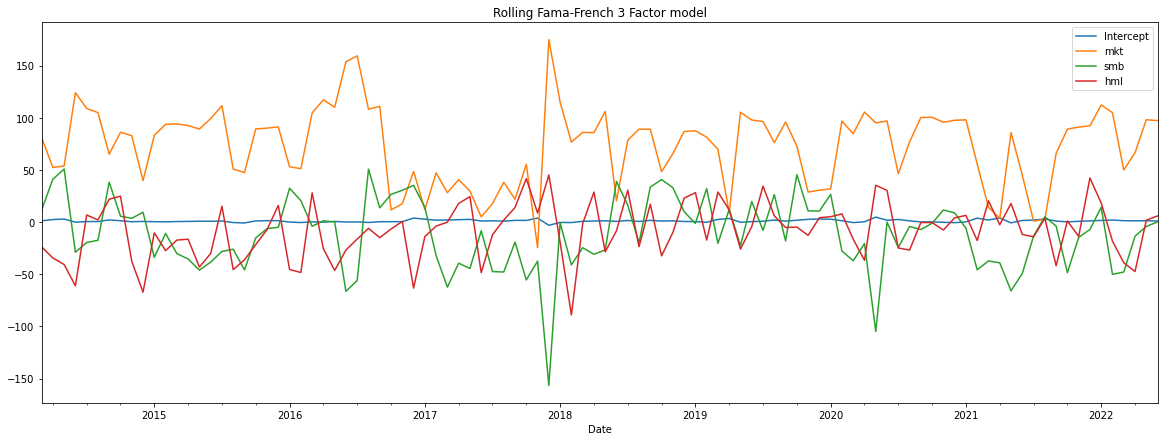

In [43]:
plt.figure(figsize=(20, 7))

results.plot(title=f'Rolling Fama-French 3 Factor model')

# Famma French Industry Factor Model

In [16]:
factors = ff.get_ff_industry_factors()
# factors

In [17]:
df = portf_returns.merge(factors,  left_index=True, right_index=True, how='inner')
df

portf_rtn   NoDur   Durbl   Manuf   Enrgy   HiTec   Telcm   Shops  \
Date                                                                            
2014-01-31  -0.946428 -0.0570 -0.0369 -0.0425 -0.0688 -0.0117 -0.0380 -0.0644   
2014-02-28   5.052560  0.0346  0.0787  0.0541  0.0559  0.0521  0.0263  0.0534   
2014-03-31   0.126902  0.0326 -0.0106  0.0033  0.0246 -0.0083  0.0017 -0.0058   
2014-04-30   0.148711  0.0142  0.0034  0.0093  0.0567 -0.0124  0.0039 -0.0094   
2014-05-31   3.047389  0.0344  0.0069  0.0125  0.0086  0.0349  0.0384  0.0095   
...               ...     ...     ...     ...     ...     ...     ...     ...   
2022-02-28  -2.119559 -0.0053 -0.0721 -0.0123  0.0808 -0.0515  0.0026 -0.0155   
2022-03-31   4.274480  0.0041  0.1476  0.0088  0.0998  0.0327 -0.0247  0.0303   
2022-04-30  -7.853804  0.0226 -0.1693 -0.0527 -0.0110 -0.1264 -0.1071 -0.0990   
2022-05-31   1.143524 -0.0165 -0.0883 -0.0043  0.1527 -0.0215  0.0852 -0.0409   
2022-06-30  -7.553473 -0.0387 -0.1183 -0.0945 -0.1626 -0.0833 -0.0672 -0.0773   

             Hlth    Utils   Other  
Date                                
2014-01-31  0.0157  0.0249 -0.0444  
2014-02-28  0.0649  0.0307  0.0347  
2014-03-31 -0.0254  0.0268  0.0233  
2014-04-30 -0.0029  0.0397 -0.0164  
2014-05-31  0.0189  0.0000  0.0172  
...            ...     ...     ...  
2022-02-28 -0.0105 -0.0111 -0.0086  
2022-03-31  0.0515  0.0968  0.0152  
2022-04-30 -0.0674 -0.0371 -0.0891  
2022-05-31  0.0103  0.0479  0.0040  
2022-06-30 -0.0209 -0.0655 -0.0994  

[102 rows x 11 columns]

In [18]:
summary, results = ff.industry_factor_model(df)

In [19]:
print(summary)

                            OLS Regression Results                            
Dep. Variable:              portf_rtn   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     509.0
Date:                Wed, 24 Aug 2022   Prob (F-statistic):           2.80e-75
Time:                        01:45:45   Log-Likelihood:                -81.137
No. Observations:                 102   AIC:                             184.3
Df Residuals:                      91   BIC:                             213.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5405      0.060      9.051      0.0

<AxesSubplot:title={'center':'Rolling Fama-French Industry Factor model'}, xlabel='Date'>

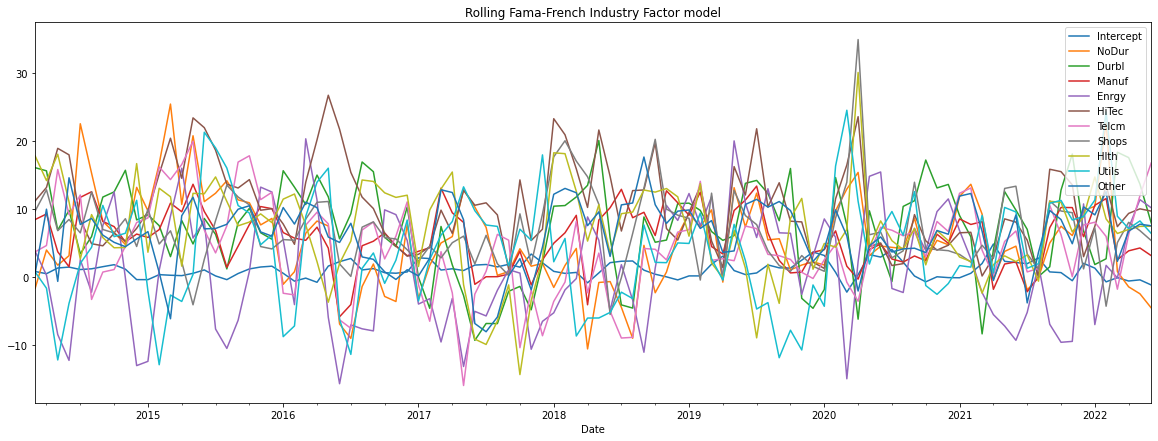

In [20]:
plt.rcParams["figure.figsize"] = (20,7)

results.plot(title=f'Rolling Fama-French Industry Factor model')

# Brinson Attribution

In [21]:
tickers = Tickers().get()

In [22]:
def get_sector(ticker):
    try:
        return tickers[tickers.ticker == ticker]['sector'].values[0]
    except Exception as e:
        return ''

In [23]:
START_DATE = '2022-01-01'
def join_returns(df):
    rets, tickers = [], []
    for ticker in df.Symbol:
        rets.append(yf.download(ticker, START_DATE, cal.today(), progress=False)['Adj Close'].pct_change().sum())
        tickers.append(get_sector(ticker))
    df['Return'] = rets
    df['Sector'] = tickers
    return df

In [24]:
portfolio = pd.DataFrame([
    ['JPM', 25],
    ['BLK', 25],
    ['AMZN', 25],
    ['JNJ', 25]
], columns = ['Symbol','Weight'])

portfolio = join_returns(portfolio)
portfolio

Symbol  Weight    Return              Sector
0    JPM      25 -0.284561  Financial Services
1    BLK      25 -0.217609  Financial Services
2   AMZN      25 -0.156524          Technology
3    JNJ      25 -0.002189          Healthcare

In [25]:
benchmark = pf[['Symbol', 'Weight']]
benchmark = join_returns(benchmark)
benchmark


1 Failed download:
- BRK.B: No data found, symbol may be delisted

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted


Symbol  Weight    Return      Sector
0     AAPL    6.63 -0.044388  Technology
1     MSFT    6.03 -0.147642  Technology
2     AMZN    3.01 -0.156524  Technology
3    GOOGL    2.12 -0.195235  Technology
4     GOOG    1.96 -0.188209            
..     ...     ...       ...         ...
498    VNO    0.01 -0.363917            
499    FOX    0.01 -0.060398            
500     RL    0.01 -0.156913            
501    PVH    0.01 -0.400776            
502    NWS    0.01 -0.206919            

[503 rows x 4 columns]

https://www.cfainstitute.org/-/media/documents/support/programs/cipm/2019-cipm-l1v1r5.ashx

For return contribution analysis, we look at portfolio weights, component security
or sector returns, and the weighted return or contribution to return. Contribution to
return is calculated as the product of the security or sector weight multiplied by the
security/sector return, as in:

 n = the number of sectors or securities in the portfolio
 wi
 = the weight of the sector or security in the portfolio
 Ri
 = the return of the sector or security in t

# VaR

VaR assumes that the price returns of our assets are normaly distributed

In [26]:
var = VaR(symbols = pf.Symbol.tolist(), weights = pf.Weight.tolist(), start_date='2020-01-01')

In [27]:
returns = var.get_returns()


1 Failed download:
- BRK.B: No data found, symbol may be delisted

1 Failed download:
- CCI: No data found for this date range, symbol may be delisted

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted


In [28]:
returns.tail()

AAPL      MSFT      AMZN     GOOGL      GOOG      TSLA  BRK.B  \
Date                                                                            
2022-08-17  0.008785 -0.002636 -0.018511 -0.017666 -0.017876 -0.008372    0.0   
2022-08-18 -0.002292 -0.003948  0.001407  0.005186  0.004488 -0.003706    0.0   
2022-08-19 -0.015102 -0.013854 -0.028602 -0.024632 -0.022671 -0.020482    0.0   
2022-08-22 -0.023029 -0.029355 -0.036244 -0.025339 -0.025821 -0.022764    0.0   
2022-08-23 -0.002029 -0.004716  0.003003 -0.003326 -0.002607  0.022558    0.0   

                 JNJ       UNH      NVDA  ...      PENN       ALK       DVA  \
Date                                      ...                                 
2022-08-17  0.000060 -0.002051 -0.028815  ... -0.031712 -0.033168 -0.035945   
2022-08-18 -0.004834  0.000404  0.023889  ... -0.008604  0.001072  0.000670   
2022-08-19  0.015231  0.005686 -0.049220  ... -0.038634 -0.026558  0.039826   
2022-08-22 -0.003508 -0.006839 -0.045661  ... -0.043098 -0.027723 -0.008797   
2022-08-23 -0.008712 -0.016104  0.008630  ...  0.007608  0.007015 -0.001082   

                DISH       VNO       FOX        RL       PVH       NWS  \
Date                                                                     
2022-08-17 -0.058552 -0.027650 -0.009188 -0.027166 -0.008312 -0.013757   
2022-08-18  0.006547 -0.000677 -0.005983  0.011109 -0.002699 -0.003219   
2022-08-19 -0.003252 -0.021003 -0.009630 -0.011592 -0.038461 -0.019376   
2022-08-22 -0.050571 -0.049135 -0.027955 -0.029676 -0.051704 -0.024149   
2022-08-23 -0.003436  0.017831 -0.005314  0.001261  0.022340 -0.006749   

            portf_rtn  
Date                   
2022-08-17  -0.681450  
2022-08-18   0.243035  
2022-08-19  -1.203512  
2022-08-22  -2.059707  
2022-08-23  -0.239959  

[5 rows x 504 columns]

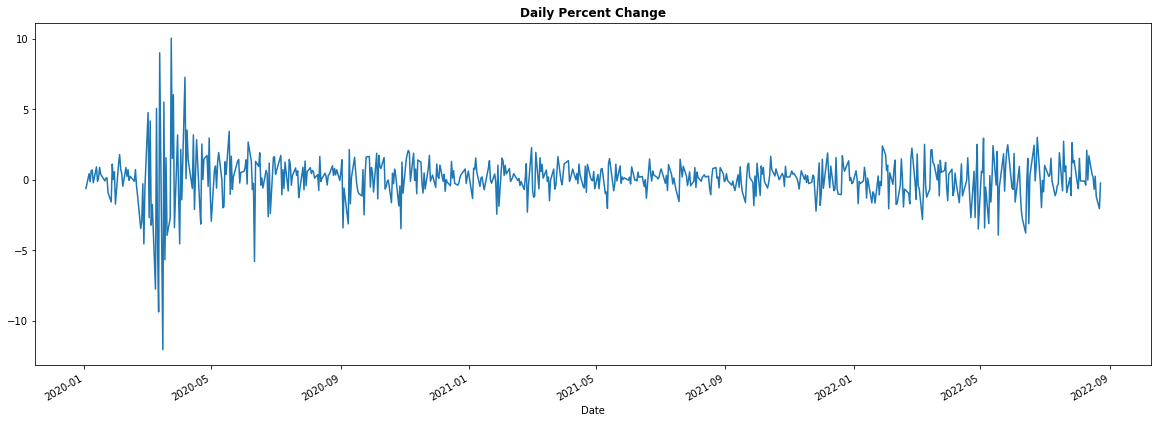

In [29]:
var.plot_daily_percent_change()

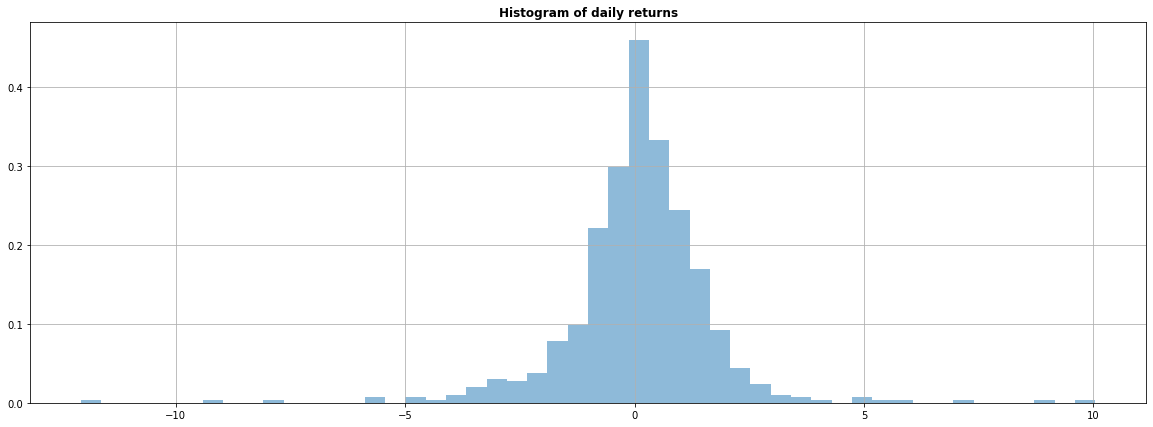

(1.6043232918268402, 0.08646357230986643, 1.6043232918268402)

In [30]:
var.plot_daily_percent_change_hist(normal=False)

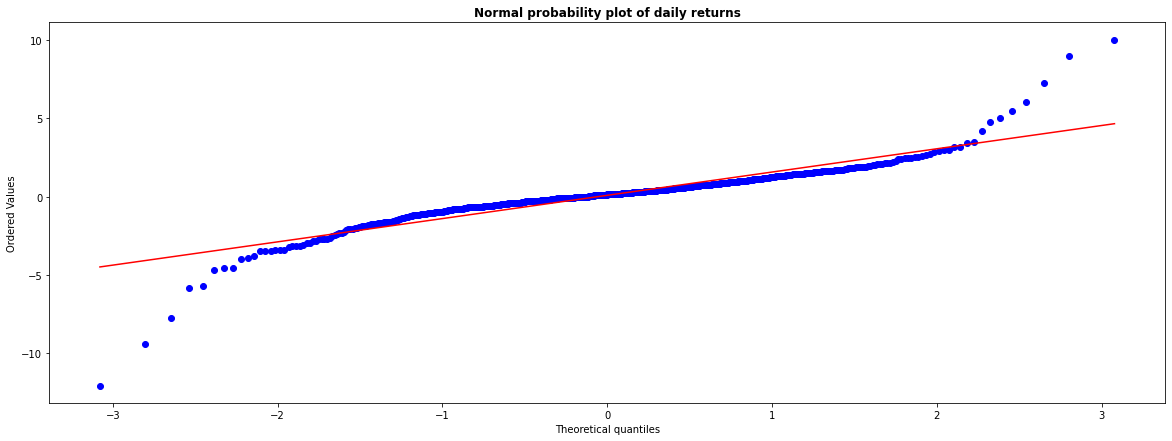

In [31]:
var_values = var.normal_distribution()

In [32]:
var_values

var90     var95     var99
0 -1.491179 -2.386556 -4.554029

The 0.05 empirical quantile of daily returns is at x. That means that with 95% confidence, our worst daily loss will not exceed x%.

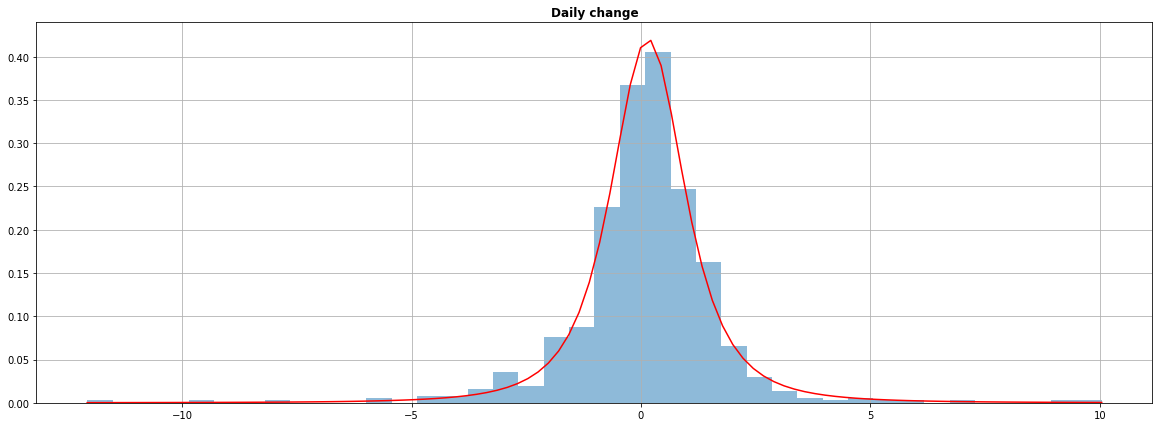

In [33]:
std, mean, sigma = var.plot_daily_percent_change_hist(normal=True)

In [34]:
scipy.stats.norm.ppf(0.05, mean, sigma)

-2.552413413054238

Monte Carlo
Now let’s run a big Monte Carlo simulation of random walks of this type, to obtain the probability distribution of the final price, and obtain quantile measures for the Value at Risk estimation.

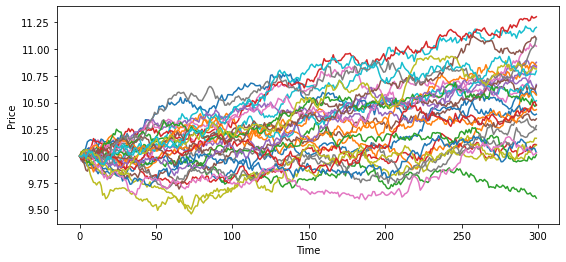

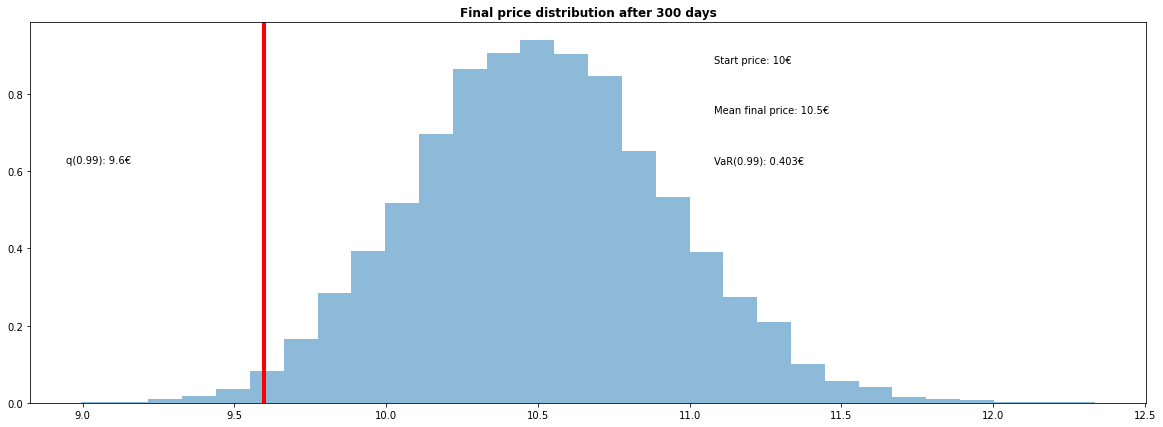

In [35]:
var.monte_carlo_var()

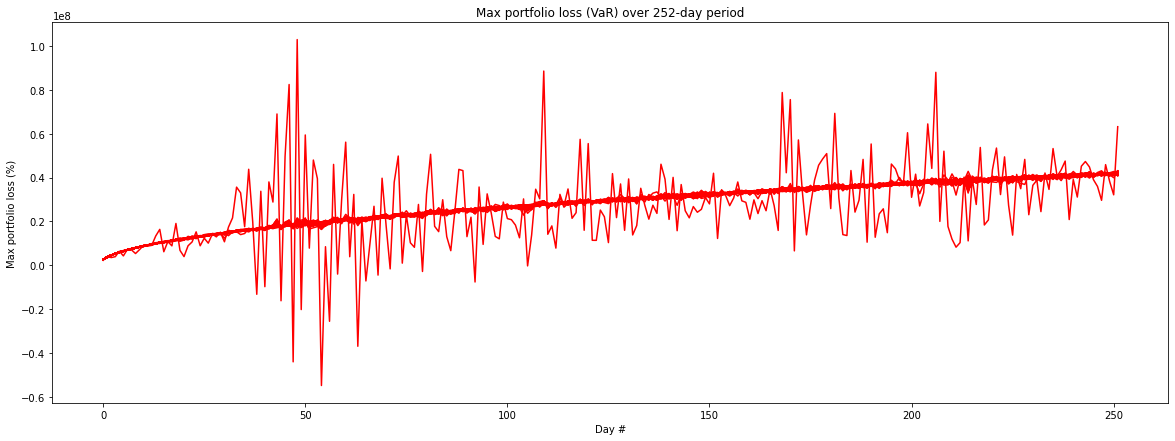

In [36]:
var.calculate_value_at_risk_over_time()